## Навигация по проекту:

1. [Знакомство с данными и подготовка их к анализу](#start)
2. [Задание функций для расчета и анализа LTV, ROI, удержания и конверсии](#functions)
3. [Исследовательский анализ данных (EDA)](#analysis)
4. [Маркетинг](#marketing)
5. [Оценка окупаемости рекламы](#roas)     
6. [Общие выводы](#conclusion)

### Шаг 0. Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

### Шаг 1. Знакомство с данными и подготовка их к анализу  <a id="start"></a> 

In [2]:
visits, orders, costs = (#код ревьюера
    pd.read_csv('visits_info_short.csv'),  # журнал сессий
    pd.read_csv('orders_info_short.csv'),  # покупки
    pd.read_csv('costs_info_short.csv'),  # траты на рекламу
)

display(visits.head(),
       orders.head(),
       costs.head())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


* Изучим столбцы и их типы

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


- Проверим на наличие явных и неявных пропусков

In [6]:
def nan_values(df,list_nans=['', ' ', '""', '" "', None, np.nan, pd.NA]):
    
    list_count=[]
    list_share=[]    
    
    for col in df.columns:
        list_count.append(sum(df[col].isin(list_nans)))
        list_share.append(round(sum(df[col].isin(list_nans)) * 100 / len(df), 2))
    
        
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'num_missing': list_count,
                                     'percent_missing': list_share})
    
    return missing_value_df

display(nan_values(visits),
        nan_values(orders),
        nan_values(costs))
        

,column_name,num_missing,percent_missing
0,User Id,0,0.0
1,Region,0,0.0
2,Device,0,0.0
3,Channel,0,0.0
4,Session Start,0,0.0
5,Session End,0,0.0


,column_name,num_missing,percent_missing
0,User Id,0,0.0
1,Event Dt,0,0.0
2,Revenue,0,0.0


,column_name,num_missing,percent_missing
0,dt,0,0.0
1,Channel,0,0.0
2,costs,0,0.0


 - Проверяем на дубликаты:

In [7]:
display('Количество обнаруженных полных дубликатов в таблице visits:', visits.duplicated().sum())
display('Количество обнаруженных полных дубликатов в таблице orders:', orders.duplicated().sum())
display('Количество обнаруженных полных дубликатов в таблице costs:', costs.duplicated().sum())

'Количество обнаруженных полных дубликатов в таблице visits:'

0

'Количество обнаруженных полных дубликатов в таблице orders:'

0

'Количество обнаруженных полных дубликатов в таблице costs:'

0

In [8]:
display('Количество обнаруженных неявных дубликатов в таблице visits:', visits[['User Id', 'Session Start']].duplicated().sum(),
        'Количество обнаруженных неявных дубликатов в таблице orders:', orders[['User Id', 'Event Dt']].duplicated().sum())

'Количество обнаруженных неявных дубликатов в таблице visits:'

0

'Количество обнаруженных неявных дубликатов в таблице orders:'

0

- Посмотрим уникальные значения категориальных данных

In [9]:
display(visits['Region'].unique(),
        visits['Device'].unique(),
        visits['Channel'].unique(),
        costs['Channel'].unique())

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

_Вывод к шагу 1:_

Для исследований мы получили три датасета. 

Датасет visits_info_short.csv хранит лог сервера с информацией о посещениях сайта и содержит следующие сведения:
User Id — уникальный идентификатор пользователя,
Region — страна пользователя,
Device — тип устройства пользователя,
Channel — идентификатор источника перехода,
Session Start — дата и время начала сессии,
Session End — дата и время окончания сессии.

Датасет orders_info_short.csv хранит данные о покупках:
User Id — уникальный идентификатор пользователя,
Event Dt — дата и время покупки,
Revenue — сумма заказа.

Датасет costs_info_short.csv — информацию о расходах на рекламу и имеет следующую структуру:
Channel — идентификатор рекламного источника,
Dt — дата проведения рекламной кампании,
Costs — расходы на эту кампанию.

Видим также:
- наименования столбцов требуют корректировки в соответствии с правилом "хорошего тона",
- есть несоответствующие содержащимся данным типы данных.


In [10]:
#переименуем столбцы

visits.columns = visits.columns.str.lower()
visits.rename(columns={'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'}, inplace=True)

orders.columns = orders.columns.str.lower()
orders.rename(columns={'user id': 'user_id', 'event dt': 'event_dt'}, inplace=True)

costs.columns = costs.columns.str.lower()

In [11]:
# преобразуем данные о времени

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Для анализа нам понадобится расчет бизнес-показетелей: конверсии, удержания, LTV, CAC и ROI. Чтобы не прописывать длинный код к каждому запросу заново, зададим функции.

### Шаг 2. Задание функций для расчета и анализа LTV, ROI, удержания и конверсии <a id="functions"></a> 

In [12]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [13]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

А также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi():

In [15]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [18]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Шаг 3. Исследовательский анализ данных <a id="analysis"></a> 


•	 Создадим пользовательские профили. 

In [19]:
#функция для создания профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Получим профили пользователей. Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу.

In [20]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [21]:
#Определим минимальную и максимальную даты привлечения пользователей

min_acquitision_dt = profiles['dt'].min()
max_acquitision_dt = profiles['dt'].max()
display(min_acquitision_dt, max_acquitision_dt)

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

Теперь проанализируем имеющиеся данные, выясним, где продукт наиболее популярен, откуда приходят качественные клиенты.

•	 Выясним, из каких стран пользователи приходят в приложение, и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [22]:
display('Общее количество пользователей:', profiles['user_id'].nunique(),
        'Общее количество платящих пользователей:', profiles['payer'].sum(),
        'Общая конверсия:', round(profiles['payer'].mean(), 2))

'Общее количество пользователей:'

150008

'Общее количество платящих пользователей:'

8881

'Общая конверсия:'

0.06

In [23]:
regions = profiles.groupby('region').agg({'user_id':'nunique', 'payer':['sum', 'mean']})
regions.sort_values(('payer', 'mean'), ascending=False)

user_id payer          
              nunique   sum      mean
region                               
United States  100002  6902  0.069019
Germany         14981   616  0.041119
UK              17575   700  0.039829
France          17450   663  0.037994

•	 Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [24]:
devices = profiles.groupby('device').agg({'user_id':'nunique', 'payer':['sum', 'mean']})
devices.sort_values(('payer', 'mean'), ascending=False)

user_id payer          
        nunique   sum      mean
device                         
Mac       30042  1912  0.063644
iPhone    54479  3382  0.062079
Android   35032  2050  0.058518
PC        30455  1537  0.050468

•	 Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [25]:
channels = profiles.groupby('channel').agg({'user_id':'nunique', 'payer':['sum', 'mean']})
channels.sort_values(('payer', 'mean'), ascending=False)

user_id payer          
                   nunique   sum      mean
channel                                   
FaceBoom             29144  3557  0.122049
AdNonSense            3880   440  0.113402
lambdaMediaAds        2149   225  0.104700
TipTop               19561  1878  0.096007
RocketSuperAds        4448   352  0.079137
WahooNetBanner        8553   453  0.052964
YRabbit               4312   165  0.038265
MediaTornado          4364   156  0.035747
LeapBob               8553   262  0.030633
OppleCreativeMedia    8605   233  0.027077
organic              56439  1160  0.020553

_Вывод к шагу 3:_

Уровень конверсии, в целом, очень низкий: всего 6% всех попробовавших приложение пользователей в последствии сделали какую-либо покупку. При этом:
- самая высокая конверсия в покупателя наблюдается в США (это 7% американских пользователей), в остальных странах конверсия держится на уровне 4%;
- большинство покупателей пользуется Mac и iPhone, реже устройствами на Android, еще реже - PC (но выраженной разницы нет, конверсия в пределах 5-6,5%);
- наибольшее число конвертировавшихся можно наблюдать в группах пользователей, привлеченных рекламой FaceBoom, AdNonSense,  lambdaMediaAds и TipTop (конверсия 10-12% с незначительной разницей в 0,5-1%).

Посмотрели, как формировались доходы компании, посмотрим, как осуществлялись расходы.

### Шаг 4. Маркетинг  <a id="marketing"></a> 

- Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. 

In [26]:
costs_total = costs['costs'].sum()
costs_by_channel = costs.pivot_table(index='channel', values='costs', aggfunc=['sum', (lambda x: sum(x)/costs_total*100)])
display(costs_by_channel.sort_values(('sum', 'costs'), ascending=False))
display('Общая сумма расходов на маркетинг составила', round(costs_total,2))

,sum,<lambda>
,costs,costs
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436


'Общая сумма расходов на маркетинг составила'

105497.3

- Визуализируем изменения метрик во времени.

In [27]:
#располагаем данными за 1 год, значит, можем просто вычленить номер месяца и недели:
import warnings
warnings.filterwarnings("ignore")
costs['month'] = pd.DatetimeIndex(costs['dt']).month
costs['week'] = pd.DatetimeIndex(costs['dt']).week

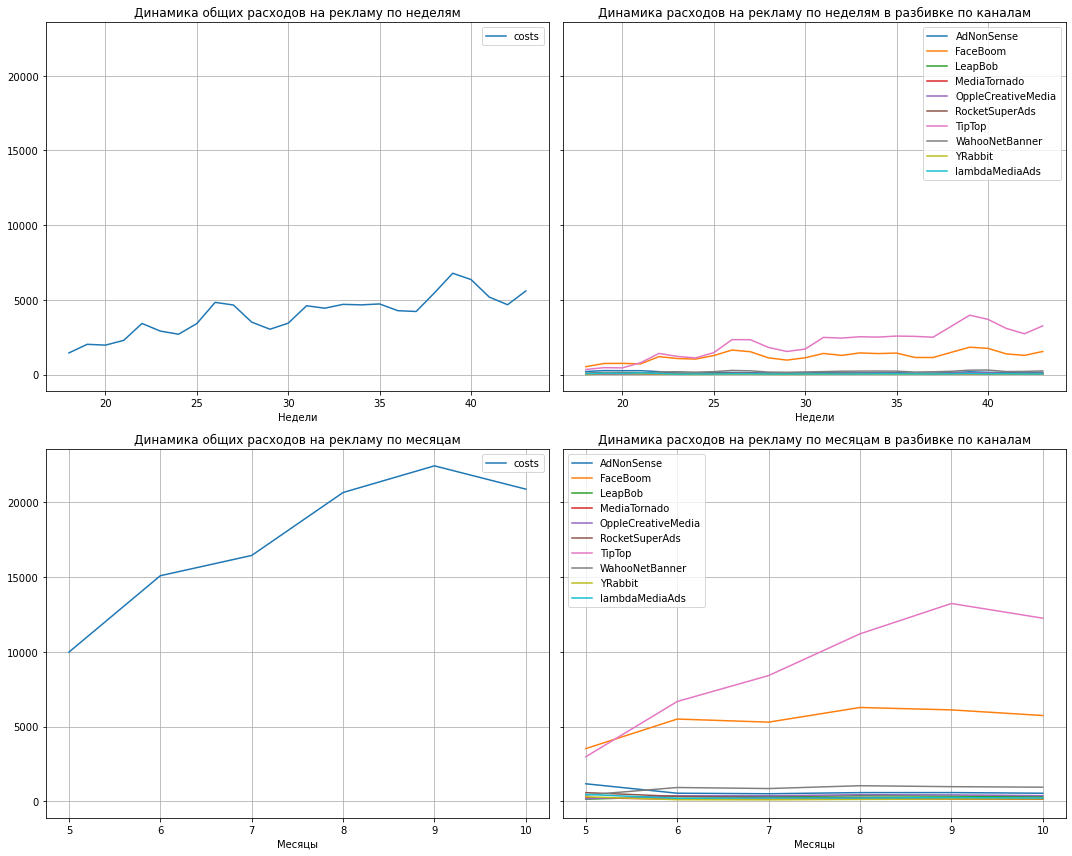

In [28]:
plt.figure(figsize=(15, 12))

ax1 = plt.subplot(2, 2, 1)
costs.pivot_table(index='week', values='costs', aggfunc='sum').plot(grid=True, ax=ax1)
plt.xlabel('Недели')
plt.title('Динамика общих расходов на рекламу по неделям')

ax2 = plt.subplot(2, 2, 2, sharey=ax1)
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('Недели')
plt.title('Динамика расходов на рекламу по неделям в разбивке по каналам')

ax3 = plt.subplot(2, 2, 3, sharey=ax1)
costs.pivot_table(index='month', values='costs', aggfunc='sum').plot(grid=True, ax=ax3)
plt.xlabel('Месяцы')
plt.title('Динамика общих расходов на рекламу по месяцам')

ax4 = plt.subplot(2, 2, 4, sharey=ax1)
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True, ax=ax4)
plt.legend()
plt.ylabel('Суммарные расходы')
plt.xlabel('Месяцы')
plt.title('Динамика расходов на рекламу по месяцам в разбивке по каналам')

plt.tight_layout()
plt.show() 

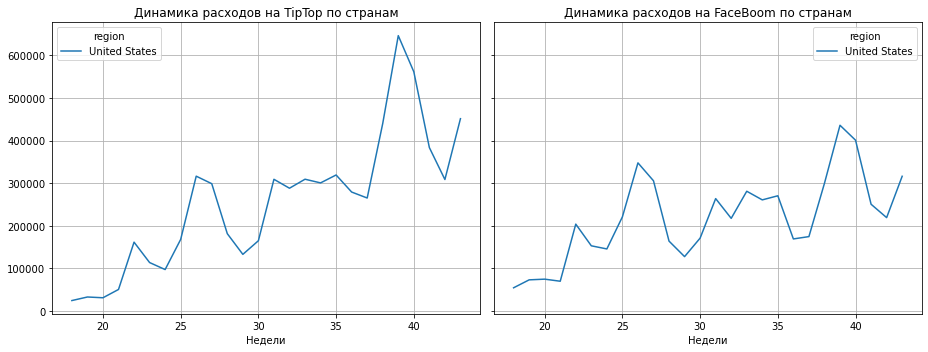

In [29]:
subtab = profiles.merge(costs, how='left', on = ['dt', 'channel']).fillna(0)

plt.figure(figsize=(13, 5))

ax1 = plt.subplot(1, 2, 1)
subtab.query('channel == "TipTop"').pivot_table(index='week', columns='region', values='costs', aggfunc='sum').plot(grid=True, ax=ax1)
plt.xlabel('Недели')
plt.title('Динамика расходов на TipTop по странам')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
subtab.query('channel == "FaceBoom"').pivot_table(index='week', columns='region', values='costs', aggfunc='sum').plot(grid=True, ax=ax2)
plt.xlabel('Недели')
plt.title('Динамика расходов на FaceBoom по странам')

plt.tight_layout()
plt.show()

Общая сумма расходов на маркетинг составила 105497.3 (пусть будет долларов). Расходы на рекламу неуклонно росли: с начала изучаемого периода сумма выросла с 10 тысяч до 22-23 тысяч в месяц (в сентябре). При этом свыше половины этой суммы было потрачено на рекламу в TipTop, чуть меньше трети - на рекламу в FaceBoom, на остальные источники - несоизмеримо меньше - от 1 до 5%.

При дополнительном рассмотрении расходов на рекламу на двух дорогих каналах - TipTop и FaceBoom - по странам выяснилось, что каналы использовали только в Америке.

Посмотрим, было ли это оправданно.


- Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника.

Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. 

In [30]:
paid_profiles = profiles.query('channel != "organic"')

display('Средний CAC на одного пользователя для всего проекта:', 
        paid_profiles['acquisition_cost'].mean())

display(
    'Средний CAC на одного пользователя для каждого источника трафика:', 
    paid_profiles.groupby('channel').agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values('cac', ascending=False))   

'Средний CAC на одного пользователя для всего проекта:'

1.127481323942928

'Средний CAC на одного пользователя для каждого источника трафика:'

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Интересно сравнить средний САС канала с конверсией:

In [31]:
cr_cac_tab = paid_profiles.groupby('channel').agg({'user_id':'nunique', 'payer':['sum', 'mean'], 'acquisition_cost': 'mean'})
cr_cac_tab.sort_values(('acquisition_cost','mean'), ascending=False)

user_id payer           acquisition_cost
                   nunique   sum      mean             mean
channel                                                    
TipTop               19561  1878  0.096007         2.799003
FaceBoom             29144  3557  0.122049         1.113286
AdNonSense            3880   440  0.113402         1.008054
lambdaMediaAds        2149   225  0.104700         0.724802
WahooNetBanner        8553   453  0.052964         0.602245
RocketSuperAds        4448   352  0.079137         0.412095
OppleCreativeMedia    8605   233  0.027077         0.250000
YRabbit               4312   165  0.038265         0.218975
MediaTornado          4364   156  0.035747         0.218717
LeapBob               8553   262  0.030633         0.210172

_Вывод к шагу 4:_

Выходит, каждый пользователь, пришедший по рекламе от TipTop, обходится компании в 2,8 доллара, что в 2,5 раз больше средней стоимости привлечения каждого нового пользователя (1,13 доллара). Для сравнения: стоимость пользователя, полученного от FaceBoom, - 1,11 доллара.

Кроме того, с этой точки зрения выглядят довольно выгодными каналы:
- AdNonSense: приводят 11% покупателей, САС на одного - 1 доллар;
- lambdaMediaAds: 10% покупателей, САС - 0,7 доллара;
- RocketSuperAds: конверсия 8%, САС - 0,4 доллара.

Но посмотрим, так ли это на самом деле, изучим окупаемость затрат.

### Шаг 5. Оценка окупаемости рекламы  <a id="roas"></a> 

- Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [32]:
# установим момент и горизонт анализа данных
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14 #согласно бизнес-плану, затраты на рекламу должны окупаться в двухнедельный срок

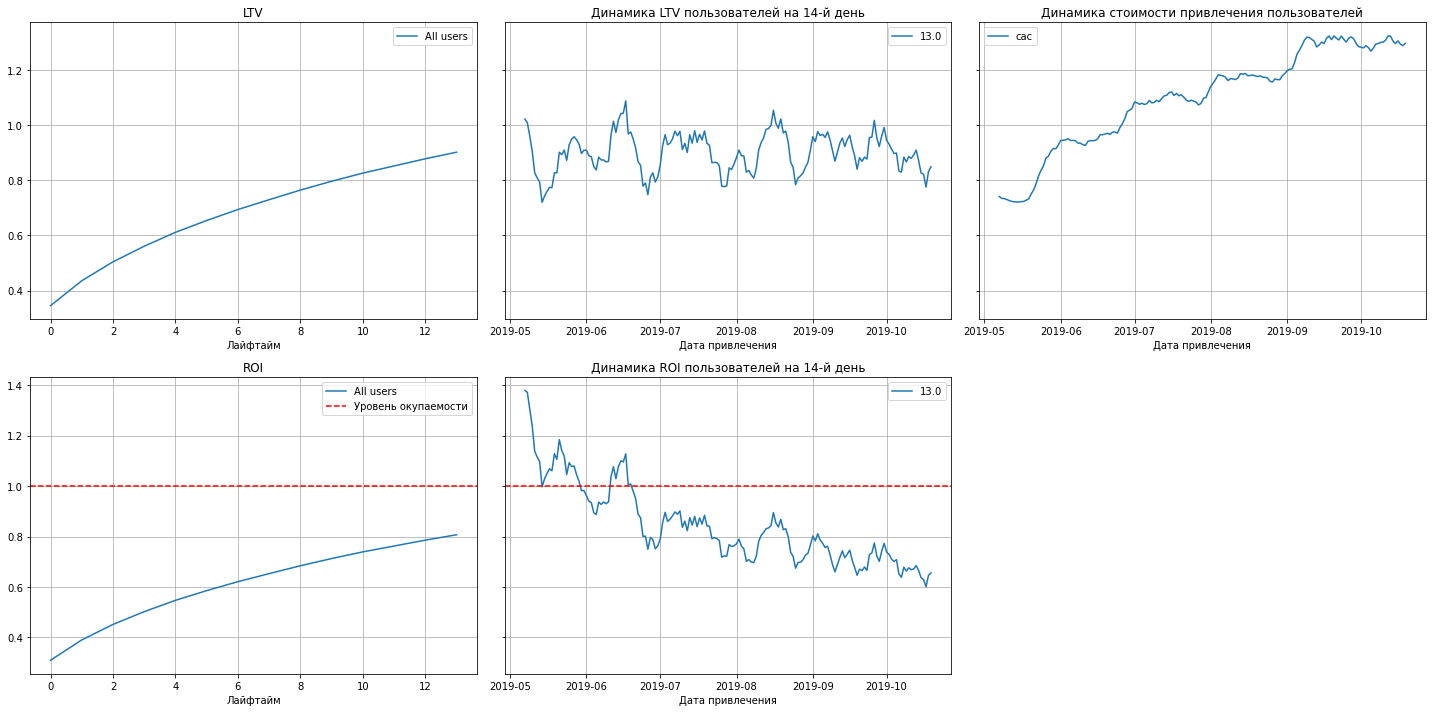

In [33]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:

- Реклама не окупается. ROI в конце принятого периода окупаемости едва превышает 80%. Реклама безвозвратно ушла в убыток уже в середине июня.
- LTV максимален в середине месяца, но генерально показатель достаточно стабилен (и колеблется в диапазоне 0,8-1 доллара). Значит, дело не в ухудшении качества пользователей.
- CAC неуклонно растет (двукратный рост в течение периода). Похоже, дело в увеличении рекламного бюджета.

Детализируем выводы, пройдём по доступным маркерам — рекламным каналам, странам и устройствам.
Начнём с разбивки по рекламным каналам: 

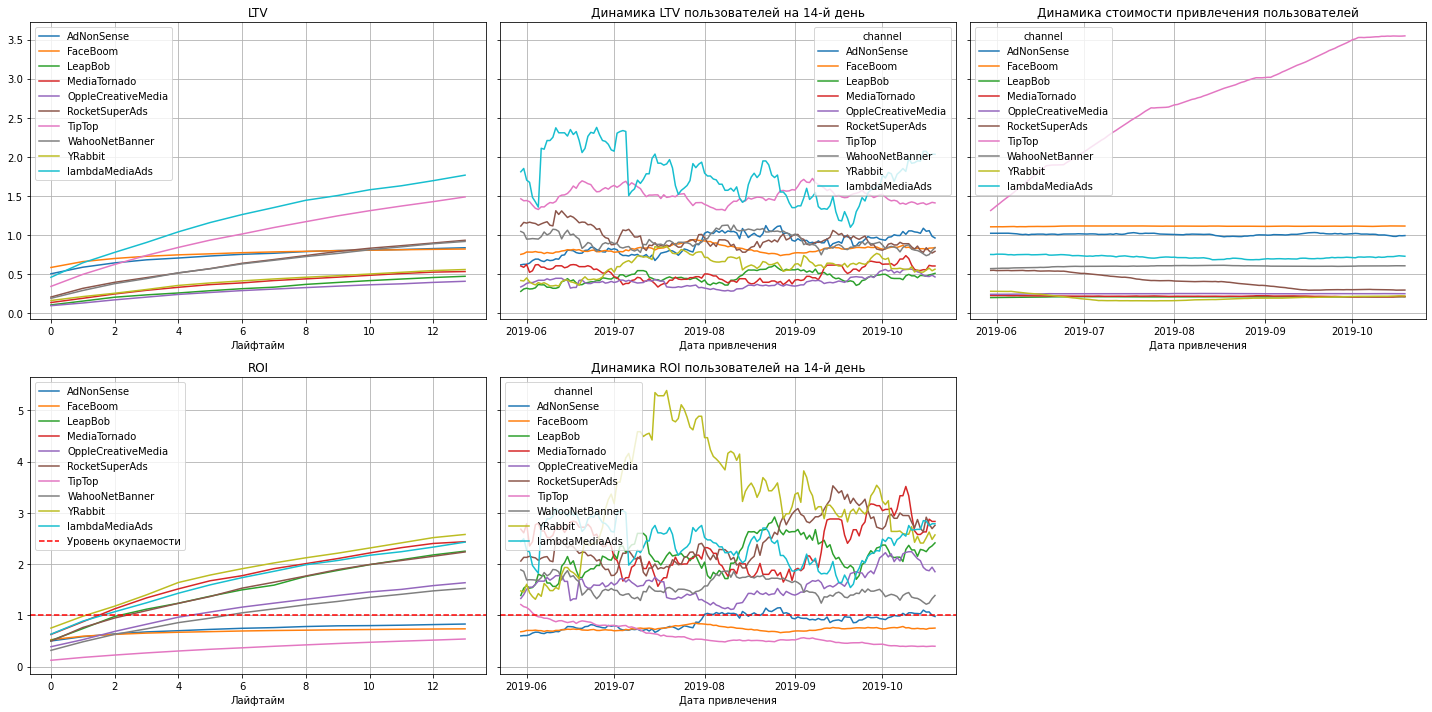

In [34]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days, dimensions = ['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
) 

Что можно отметить:
- три канала: TipTop, FaceBoom, AdNonSense не выходят в окупаемость в двухнедельный срок, и первые два канала не окупаются вообще;
- каналы RocketSuperAds, MediaTornado, lambdaMediAds и LeapBob выглядят потенциально перспективными: их графики вовзрата на инвестиции растут с течением времени;
- при этом видим, что расходы на рекламу по всему перечню каналов не менялись, и только в TipTop с июня стали вливать дополнительные деньги, так что его CAC неуклонно растет и заметно превышает САС всех других каналов.  

Похоже, на окупаемость продукта повлияла неудачная реклама в этом канале.

Но проверим окупаемость по странам.

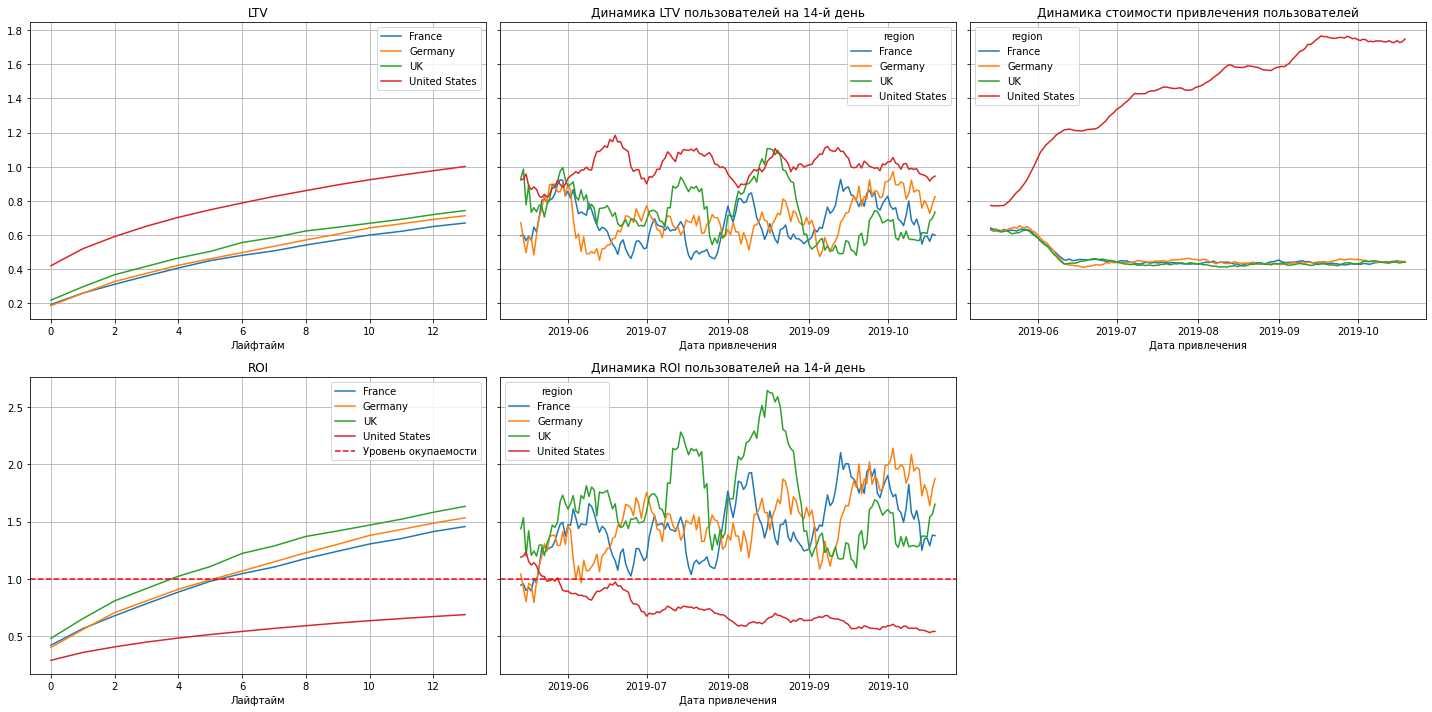

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Здесь разница поведения графиков явная:

LTV покупателей всех стран стабилен, и действительно, стоимость заказов пользователей из США на 50% выше стоимости заказов остальных пользователей. Но затраты на рекламу в этом регионе постоянно растут и сильно превышают рекламный бюджет, потраченный в других странах. С конца мая затраты на покупателей из США не окупаются. 
Учитывая стабильность стоимости привлечения и полной окупаемости рекламы в Германии, Франции и Великобритании, можем заключить, что маркетинговый провал случился в США.

Для полной картины: посмотрим разбивку по устройствам.

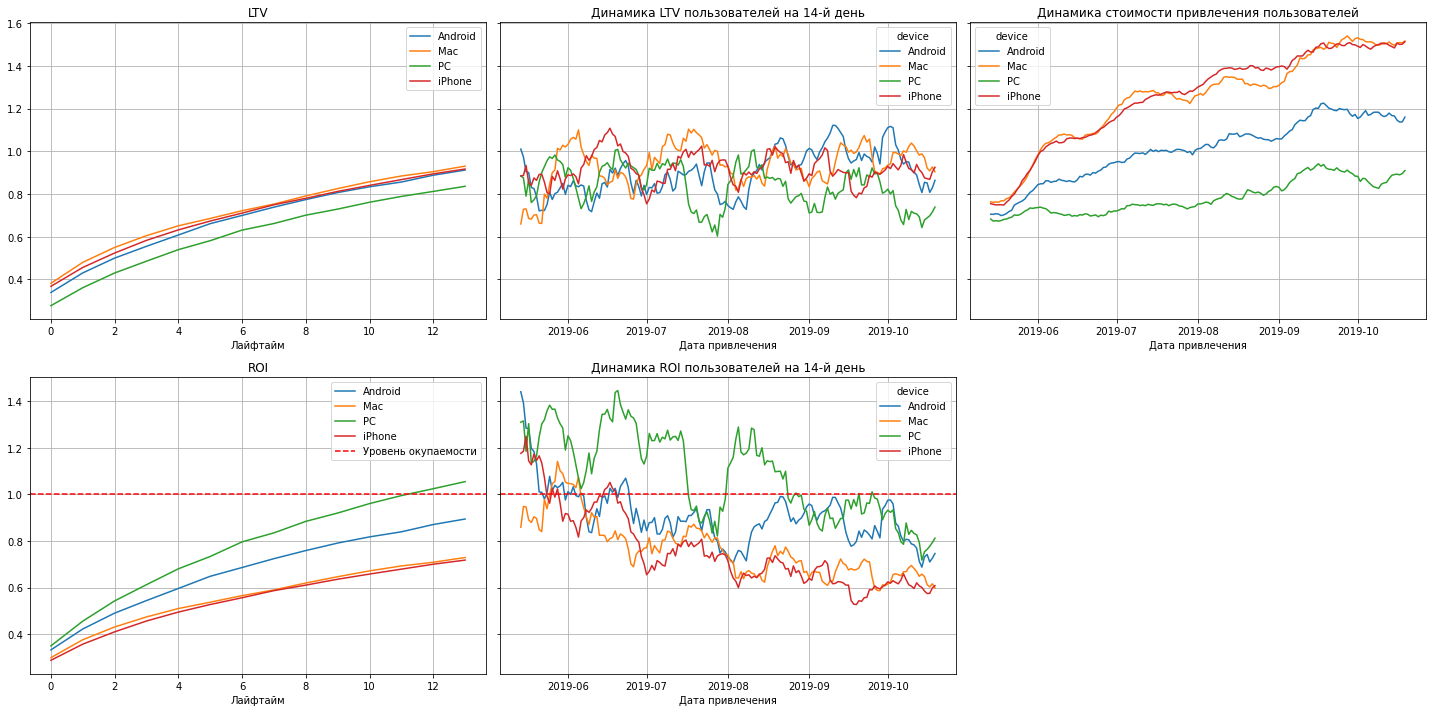

In [36]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 



Графики динамики LTV на всех устройствах примерно равные и стабильные. При этом ROI с каждым месяцем падает, значит, растут расходы на привлечение.
Самая высокая стоимость привлечения у Mac и iPhone, их линии CAC и ROI практически совпадают.

- Узнаем, в чём причина: в низкой конверсии или низком удержании.

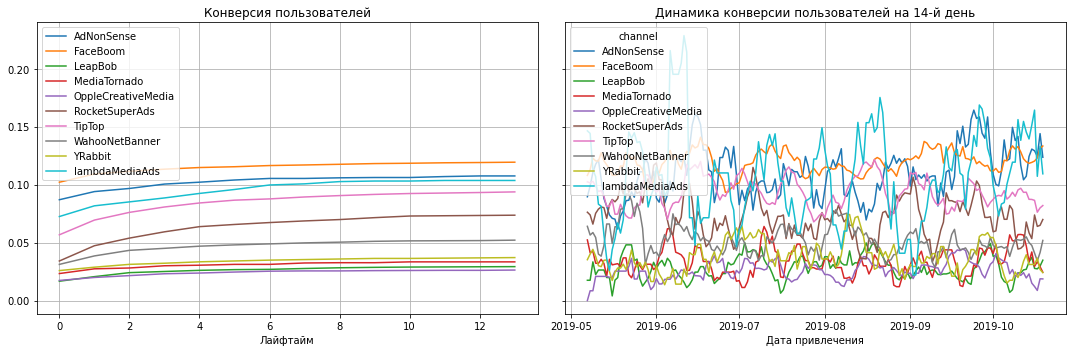

In [37]:
#посчитаем и визуализируем конверсию с разбивкой по рекламным каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия проходит ровно и стабильно (самые высокие показатели - FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds). Значит, проблема не в ней.

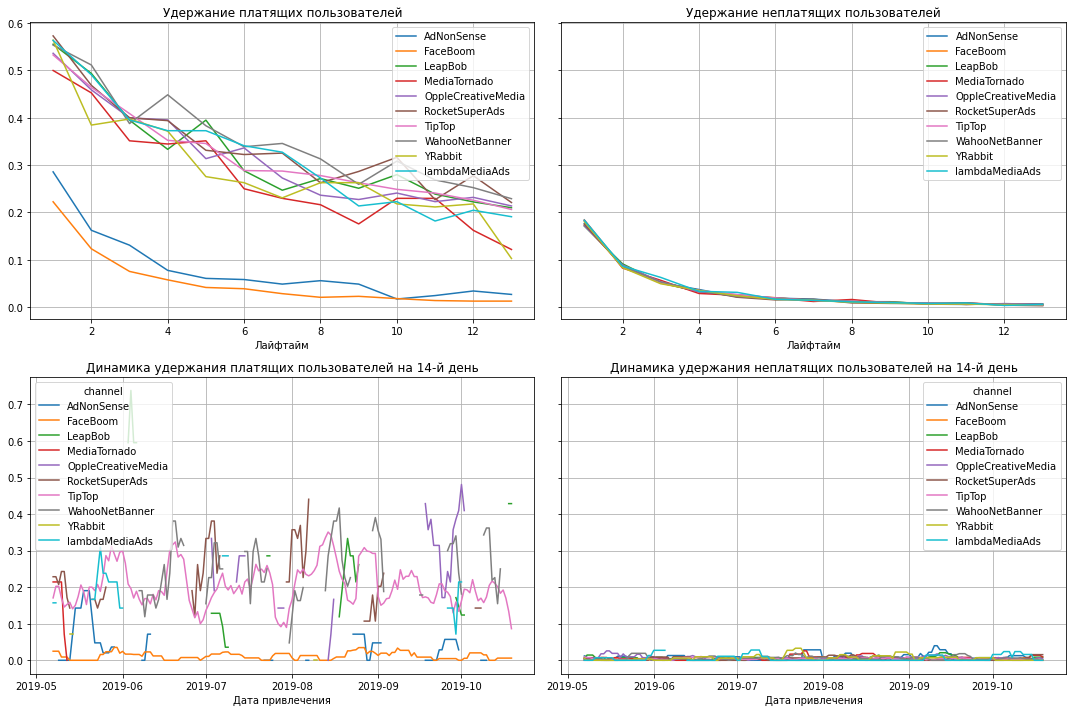

In [38]:
#смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    paid_profiles, visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей, в целом, стабильно, хоть и не на высоком уровне. Правда, как мы рассчитыали, таких пользователей всего 6%. Не ставшие покупателями клиенты не пользуются приложением, так же, как клиенты, пришедшие от AdNonSense и FaceBoom и оплатившие хоть одну покупку, - к концу второй недели число возвращающихся стремится к нулю.
Глядя на динамику удержания, можно предположить, что пользование приложением платное, и пробный период не превышает 10 дней. Для более содержательного анализа нужны дополнительные данные о самом продукте.

Но таких данных у нас нет, а на основании имеющихся можем пристальнее рассмотреть удержание по трем "проблемным" каналам: самому дорогому в нашем бюджете и неудерживающим даже платящих пользователей.

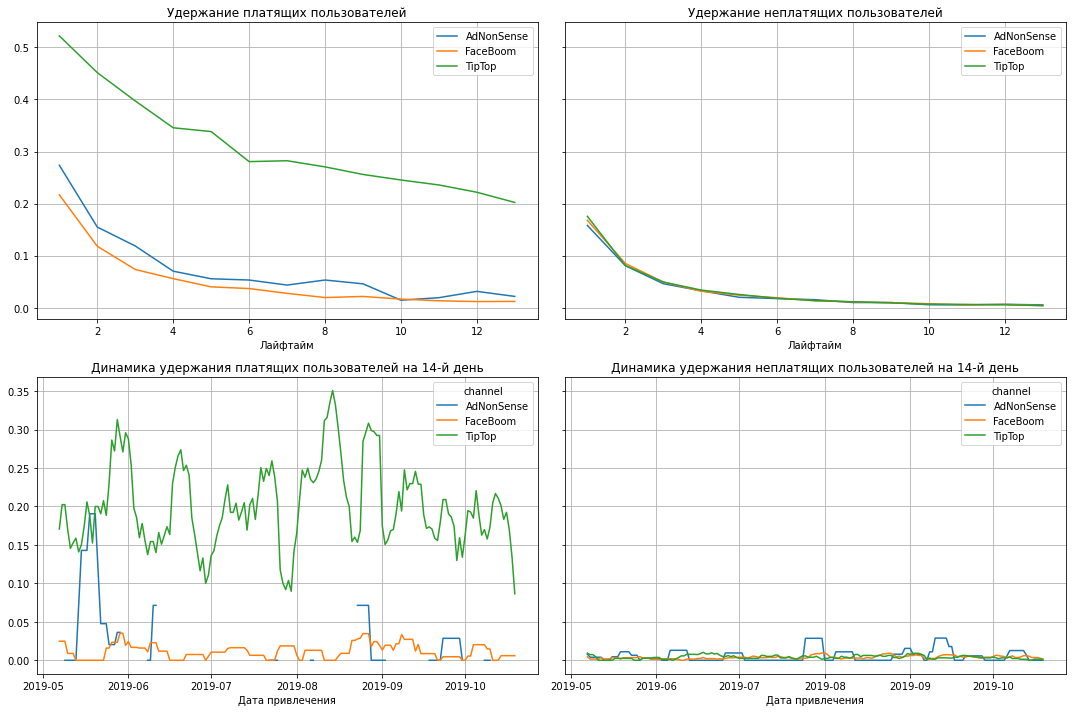

In [39]:
#смотрим удержание с разбивкой по каналам TipTop, FaceBoom, AdNonSense

retention_raw, retention_grouped, retention_history = get_retention(
    paid_profiles.loc[profiles['channel'].isin(['TipTop', 'FaceBoom', 'AdNonSense'])],
    visits.loc[visits['channel'].isin(['TipTop', 'FaceBoom', 'AdNonSense'])],
    observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Очевидно, что реклама FaceBoom приводит преимущественно "одноразовых" пользователей. А провалы в графике динамики удержания AdNonSense могут говорить о нестабильности работы с этим каналом. Похоже, с середины июня по вторую половину августа, а также и по некоторым другим периодам просто нет данных.

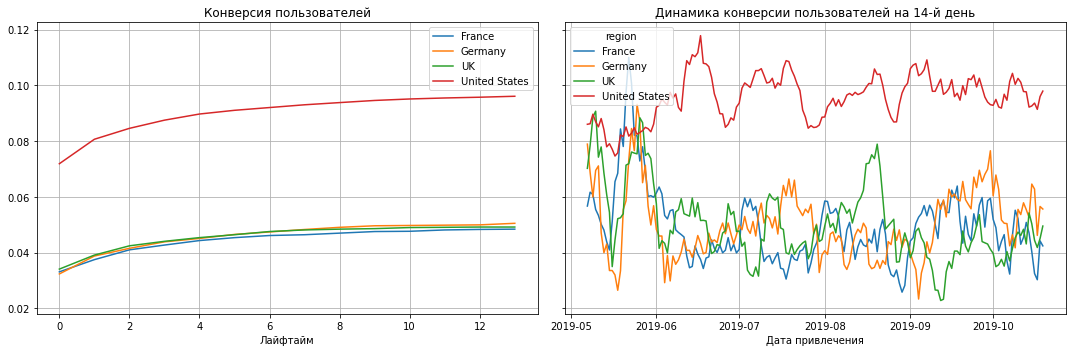

In [40]:
#посчитаем и визуализируем конверсию с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 



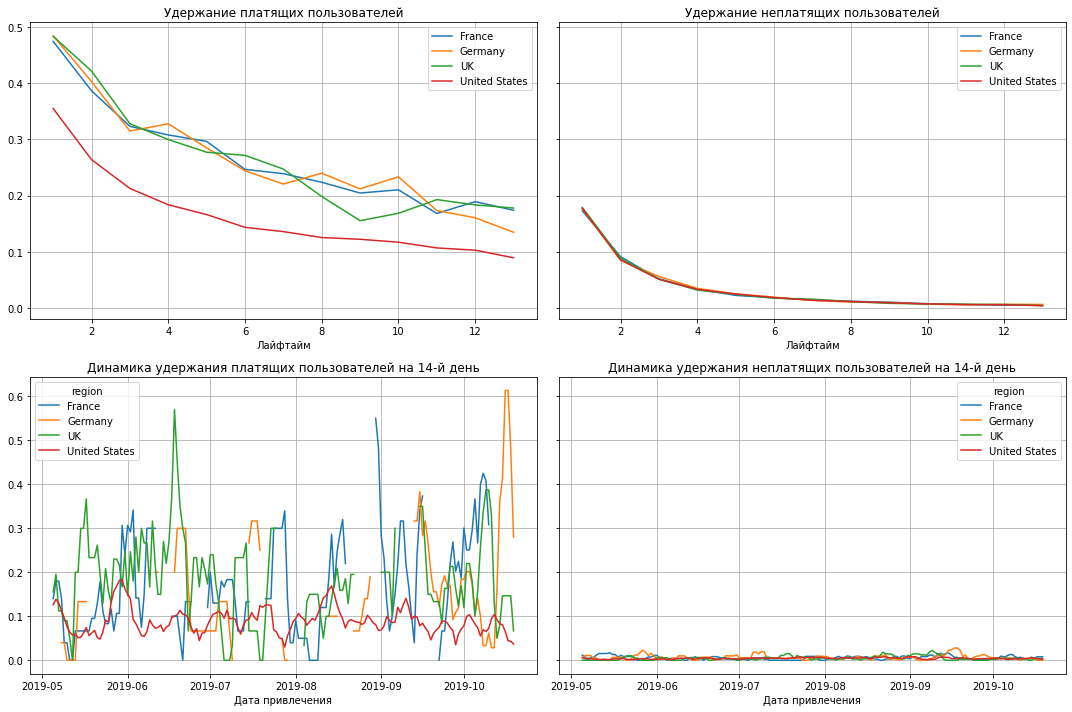

In [41]:
# удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    paid_profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days, window=5) 

Активность пользователей Франции, Германии и Великобритании не различается по странам: конверсия и удержание стабильны и схожи по значениям между собой. На их фоне заметно выделяются США: уровень конверсии в два раза выше (а поведение графиков удержания и динамики удержания так же ровно и стабильно).

Такая стабильность может говорить о том, что внешние факторы мало влияют на поведение пользователей. Даже особо активная или масштабная реклама.

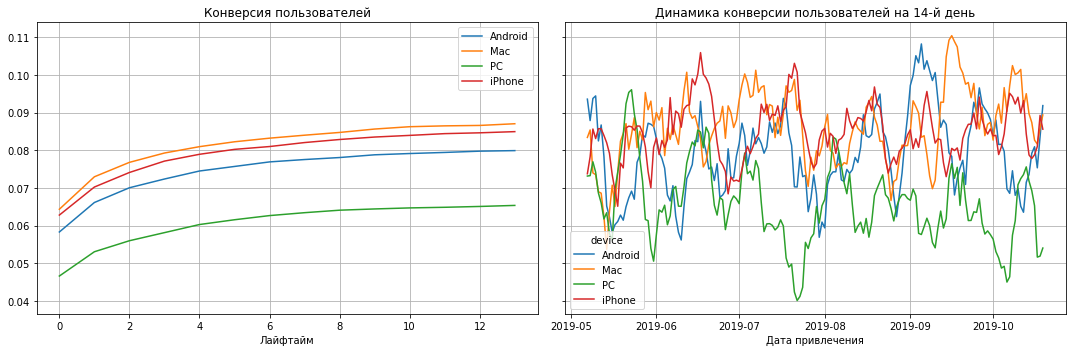

In [42]:
#конверсия по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


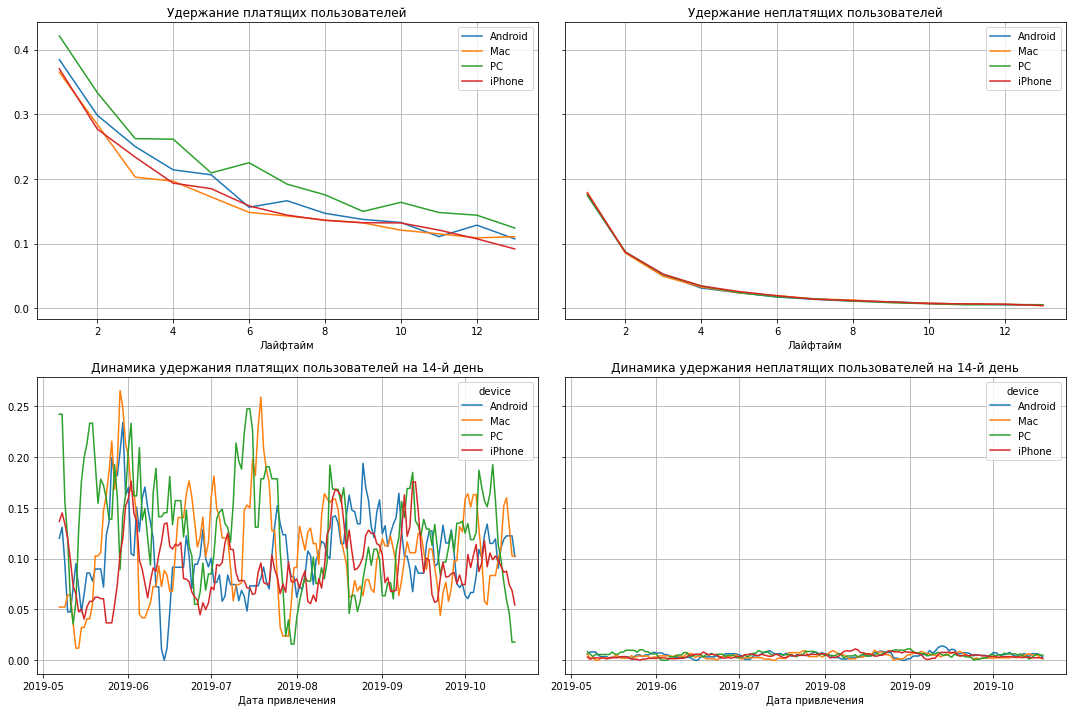

In [43]:
# удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    paid_profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days, window=7) 

Здесь графики тоже стабильны, и линии располагаются близко друг к другу. То есть использование того или иного устройства не оказывает большого влияния на конверсию и удержание. А низкие показатели конверсии для PC лишь свидетельствуют о дальнейшем снижении популярности этих устройств.

_Вывод к шагу 5:_

В целом, реклама не окупается. Наиболее вероятными причинами могут быть неудачные расходы - неоправданно большие суммы на рекламу на каналах TipTop и FaceBoom. Первый из каналов показывает те же графики конверсии и удержания, что и другие каналы, и при таком увеличении финансирования канал не может не стать убыточным. Возможно, стоит уменьшить статью расходов на него до среднего по остальным каналам и посмотреть динамику ROI. Второй из каналов приводит неудерживающихся пользователей, и возможно, от него стоило бы отказаться.


Факторы страны и устройства в поведении пользователей показали себя несущественными. Необходимо заметить лишь, что общая выручка от покупок для PC меньше сумм, приносимых с других устройств, и вероятно, не стоит инвестировать в PC большие деньги.
А значения конверсии в США, двукратно превышающие значения конверсии в других странах, показывают, что страна потенциально прибыльна, и нужно поискать подходящие инструменты рекламы.

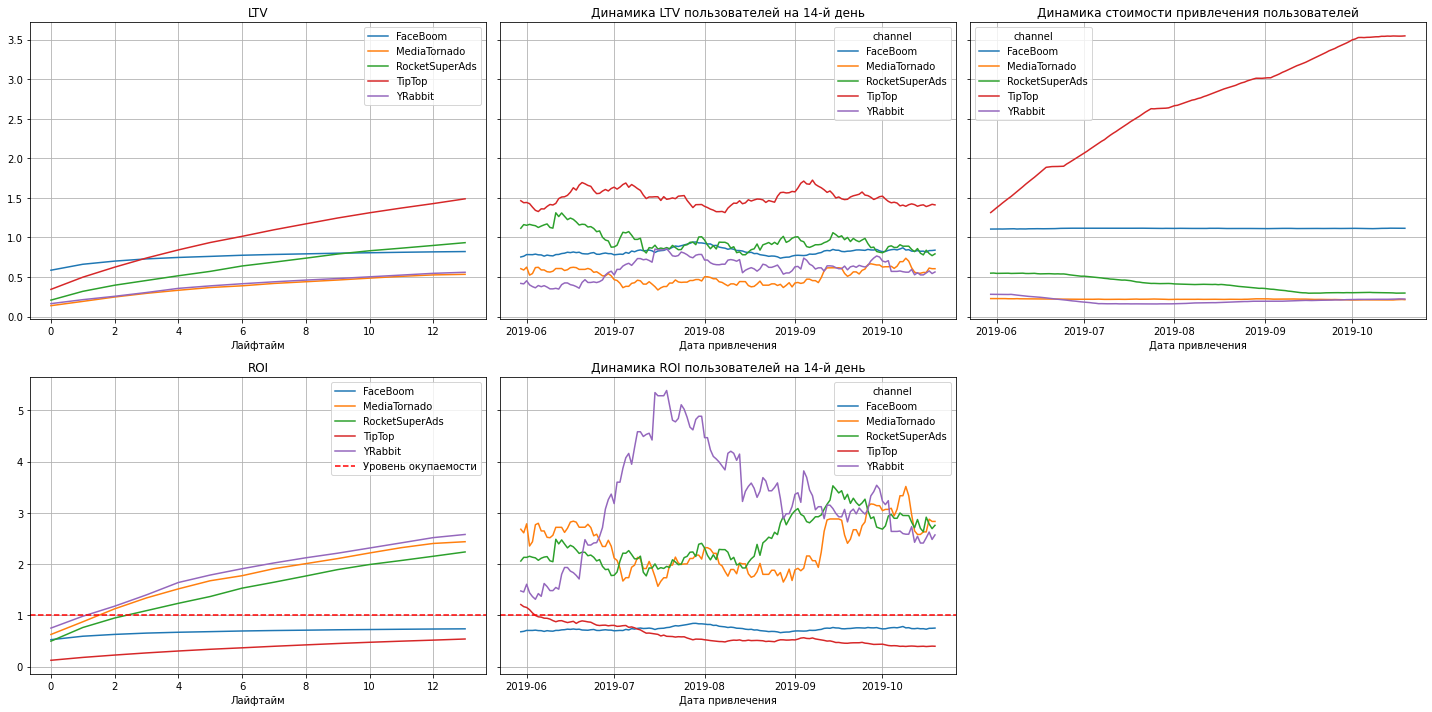

In [44]:
#посмотрим, какими каналами пользуются в США, и как ведут себя графики LTV, CAC, ROI 

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles.query('region == "United States"'), orders, observation_date, horizon_days, dimensions = ['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
) 

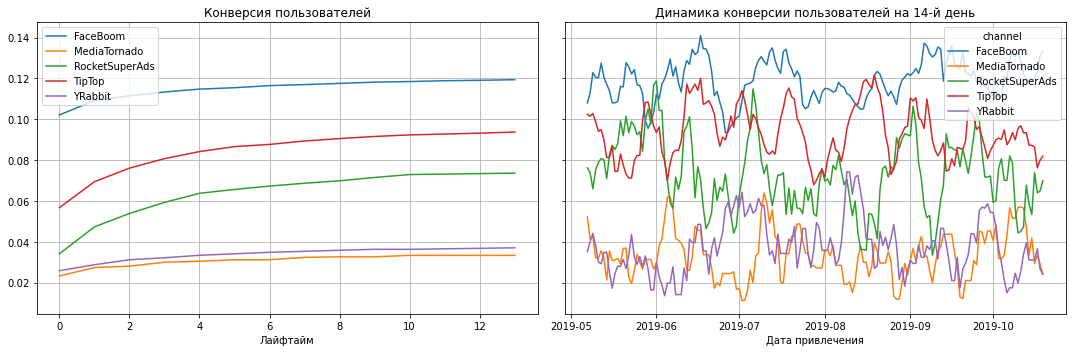

In [45]:
#посчитаем и визуализируем конверсию с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    paid_profiles.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

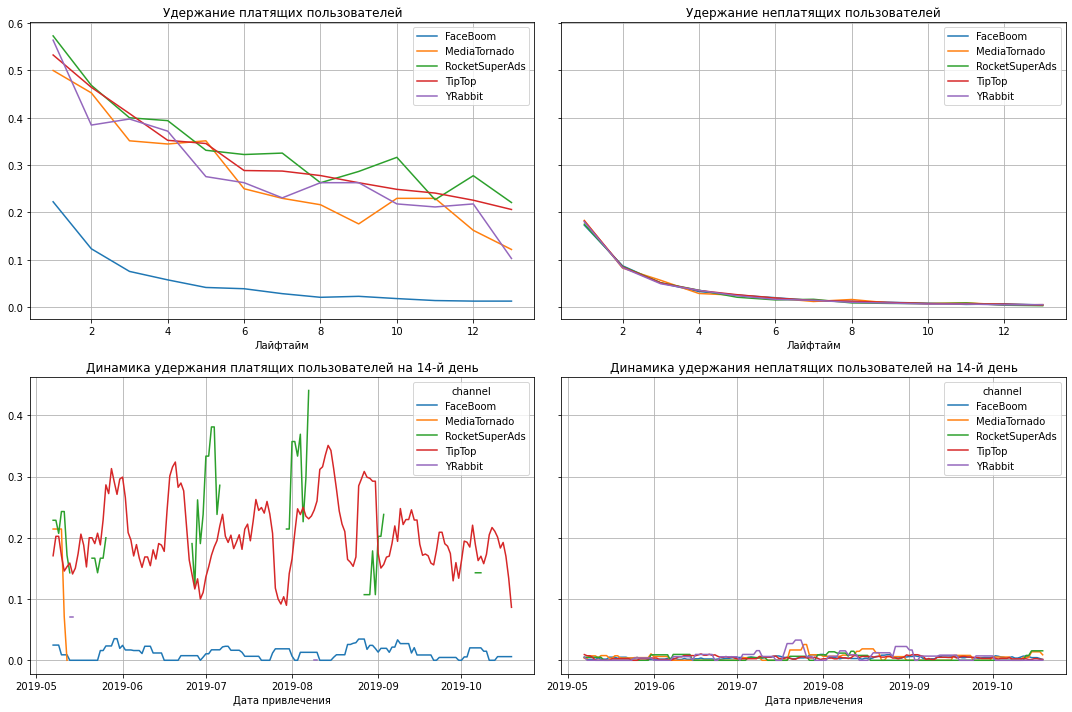

In [46]:
#смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    paid_profiles.query('region == "United States"'), visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days) 

Видим, что лучшие показатели LTV и конверсии показывают TipTop, FaceBoom и RocketSuperAds, но пришедшие с FaceBoom клиенты практически не задерживаются. Если говорить об окупаемости, то, вероятнее всего, каналу TipTop выйти в плюс мешает только чрезмерное, не соответствующее реальному потоку пользователей финансирование. Таким образом, можно рекомендовать для продаж в США снизить уровень расходов на TipTop и развивать RocketSuperAds.

#### Шаг 5.1.

Дополнительно, поскольку в нашем распоряжении есть необходимые данные, можем рассчитать показатели пользовательской активности:
- дневную (DAU), недельную (WAU) и месячную (MAU) активность пользователей,
- sticky factor,
- ASL.

In [47]:
# выделяем год, номер месяца и номер недели из времени начала сессии

visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.isocalendar().week
visits['session_date'] = visits['session_start'].dt.date

In [48]:
#посчитаем DAU, WAU, MAU

dau = visits.groupby('session_date').agg({'user_id': 'nunique'}).mean()
wau = visits.groupby('session_week') .agg({'user_id': 'nunique'}).mean()
mau = visits.groupby('session_month').agg({'user_id': 'nunique'}).mean()

display('Дневная пользовательская активность:', round(dau),
        'Недельная пользовательская активность:', round(wau),
        'Месячная пользовательская активность:', round(mau))


'Дневная пользовательская активность:'

user_id    1684.0
dtype: float64

'Недельная пользовательская активность:'

user_id    8354.0
dtype: float64

'Месячная пользовательская активность:'

user_id    28989.0
dtype: float64

In [49]:
sticky_wau = dau/ wau * 100
sticky_mau = dau/ mau * 100

display('Sticky factor для недельной аудитории :', round(sticky_wau),
       'Sticky factor для месячной аудитории :', round(sticky_mau))


'Sticky factor для недельной аудитории :'

user_id    20.0
dtype: float64

'Sticky factor для месячной аудитории :'

user_id    6.0
dtype: float64

Лояльность пользователей всего 6% (а согласно общепринятому мнению аналитиков показатель MAU, например, для игр принято считать нормальным равным 18%), клиенты не задерживаются.

Посмотрим, сколько в среднем сессий приходится на одного пользователя, например, за месяц. Это ещё один хороший показатель регулярности использования приложения, помимо sticky factor.

In [50]:
#среднее количество сессий на одного пользователя в месяц
sessions_per_user = visits.groupby('session_month').agg({'user_id': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (round(sessions_per_user['n_sessions'] / sessions_per_user['n_users'], 2))

sessions_per_user

,n_sessions,n_users,sessions_per_user
session_month,,,
5,45765,27111,1.69
6,44623,26042,1.71
7,47970,26672,1.80
8,55996,31064,1.80
9,56628,31871,1.78
10,58919,31175,1.89


В среднем, пользователи заходят в приложение 1-2 раза в месяц. Что для развлекательного приложения представляется критически редким.
Посмотрим заодно, сколько времени длится средняя сессия.

In [51]:
visits['session_duration_sec'] = (visits['session_end'] - visits['session_start']).dt.seconds

visits['session_duration_sec'].mean()

1800.0908677287264

Среднее значение показывает 30 минут.

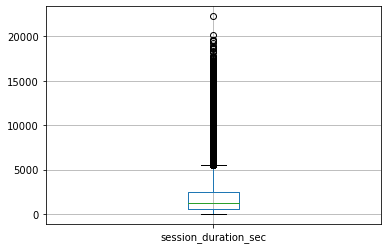

In [52]:
visits.boxplot('session_duration_sec')
plt.show()

In [53]:
visits['session_duration_sec'].median()

1244.0

Но в данных оказались сессии до 20 тысяч секунд (это более 5,5 часов), что можно приравнять к аномальным выбросам (пользователь мог просто не закрыть страницу приложения, если зашел с компьютера). И было обоснованным посчитать медианное значение, которое стало равно 20 минутам.

Это довольно длинная сессия. Выходит, пользователям, в целом, нравится продукт, они находят в нем что-то интересное и готовы потратить на него свое время, но не деньги, и по каким-то причинам редко возвращаются (или бросают после второго использования).

Может быть, платный контент? Платное использование самого приложения? Суммы, которые клиенты несогласны платить. И после пробного бесплатного периода они уходят.

Точнее на эти вопросы смогут ответить специалисты, занимающиеся самим продуктом. Они же смогут вернее оценить, какую активность и длительность сессий считать успешными. Мы можем только сообщить о найденных данных и поделиться ими. 

### Шаг 6. Общие выводы  <a id="conclusion"></a> 

Аналитическая работа была завершена, и теперь можно сказать следующее:
- Общий уровень конверсии 6%;
- Самая высокая конверсия наблюдается в США (7%), в остальных странах - 4%;
- Большинство покупателей пользуется Mac и iPhone, реже устройствами на Android, еще реже - PC (но выраженной разницы нет, конверсия в пределах 5-6,5%);
- Наибольшее число конвертировавшихся пришли от рекламы в FaceBoom, AdNonSense, lambdaMediaAds и TipTop (конверсия 10-12% с разницей в 0,5-1%);
-	Общая сумма расходов на маркетинг составила 105,5 тысяч долларов;
-	Расходы на рекламу постоянно повышались: с начала изучаемого периода сумма выросла с 10 тысяч до 22-23 тысяч в месяц (в сентябре). При этом свыше половины этой суммы было потрачено на рекламу в TipTop, чуть меньше трети - на рекламу в FaceBoom, на остальные источники - от 1 до 5%;
-	Это привело к тому, что каждый пользователь, пришедший по рекламе от TipTop, обошелся  компании в 2,8 доллара, что в 2,5 раз больше средней стоимости привлечения каждого нового пользователя. Стоимость пользователя, полученного от FaceBoom, составила 1.11 доллара (и это уже близко среднему CAC по всем каналам, равному 1,13 доллара);
-	Реклама не окупалась и стала убыточной уже с середины июня, ROI в конце принятого периода окупаемости едва превышал 80%;
-	Каналы TipTop, FaceBoom не окупались вообще. Но в рекламу TipTop с июня стали вливать дополнительные деньги, так что его CAC неуклонно рос и заметно превысил САС всех других каналов, в этом представляется причина убыточности канала;
- Дополнительно было выявлено, что убыточные каналы TipTop и FaceBoom применялись только в США;
-	LTV, в целом, был достаточно стабилен (в диапазоне 0,8-1 доллара), при этом LTV в США был выше LTV пользователей других стран на 50%;
-  CAC неуклонно рос, при этом затраты в США значительно превышали рекламный бюджет, потраченный в других странах. С конца мая затраты на покупателей из США не окупались. Учитывая стабильность стоимости привлечения и полной окупаемости рекламы в Германии, Франции и Великобритании, можем заключить, что маркетинговый провал случился в США;
- Однако, большое число пользователей и значения конверсии в США, двукратно превышающие значения конверсии в других странах, показывают, что страна потенциально прибыльна. Дополнительное исследование показало, что самыми перспективными выступают каналы TipTop и RocketSuperAds, и в качестве рекомендация отделу маркетинга я бы предложила перераспределить рекламный бюджет США между ними;
-	Учитывая, что взаимодействие с приложением во всех странах было схожим и стабильным, можно ожидать, что расширение распространения приложения на другие страны тоже даст стабильный доход, - значит, надо привлекать новые страны;
-	Кроме того, есть смысл поработать над самим продуктом  и/или его стоимостью – по каким-то причинам пользователи плохо удерживаются и плохо конвертируются в покупателей.

